The goal of this notebook is to look at my expenses and income. Maybe I'll turn it into a blog post; probably not.

Schwab only lets me download two years' worth of checking account data, so that's what we're looking at.

In [58]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates

%matplotlib inline

In [15]:
df = pd.read_csv('Schwab_Checking_Checking_Transactions_20210319-221807.CSV')

df.head()

,,,,,,Transactions for Checking account Schwab Checking XXXXXX-184849 as of 03/19/2021 22:18:08 ET
Date,Type,Check #,Description,Withdrawal (-),Deposit (+),RunningBalance
Pending Transactions are not reflected within this sort criterion.,NaN,NaN,NaN,NaN,NaN,NaN
Posted Transactions,NaN,NaN,NaN,NaN,NaN,NaN
03/17/2021,ACH,NaN,IRS TREAS 310 TAXEIP3 031721~ Tran: ACH,NaN,"$1,400.00","$71,361.62"
03/16/2021,ACH,NaN,CARDMEMBER SERV WEB PYMT 210315,$872.48,NaN,"$69,961.62"


Ah, annoying there's four rows of non-header info, and the headers are in the second row.

In [22]:
df = pd.read_csv('Schwab_Checking_Checking_Transactions_20210319-221807.CSV', skiprows=1)
df = df.iloc[2:]
df.head()

,Date,Type,Check #,Description,Withdrawal (-),Deposit (+),RunningBalance
2,03/17/2021,ACH,NaN,IRS TREAS 310 TAXEIP3 031721~ Tran: ACH,NaN,"$1,400.00","$71,361.62"
3,03/16/2021,ACH,NaN,CARDMEMBER SERV WEB PYMT 210315,$872.48,NaN,"$69,961.62"
4,03/15/2021,ACH,NaN,CITI CARD ONLINE PAYMENT 210314,$437.12,NaN,"$70,834.10"
5,03/15/2021,ACH,NaN,GUSTO PAYROLL PAY 428698 210315,NaN,"$2,956.40","$71,271.22"
6,03/03/2021,ACH,NaN,BK OF AMER MC ONLINE PMT 210303,"$1,258.72",NaN,"$68,314.82"


Awww yeah check out that stimmy check!

In [23]:
df = df.rename(columns={'Withdrawal (-)': 'withdrawal', 'Deposit (+)': 'deposit', 'Check #': 'check_num'})
df.columns = [i.lower() for i in df.columns]

In [24]:
df.head()

,date,type,check_num,description,withdrawal,deposit,runningbalance
2,03/17/2021,ACH,NaN,IRS TREAS 310 TAXEIP3 031721~ Tran: ACH,NaN,"$1,400.00","$71,361.62"
3,03/16/2021,ACH,NaN,CARDMEMBER SERV WEB PYMT 210315,$872.48,NaN,"$69,961.62"
4,03/15/2021,ACH,NaN,CITI CARD ONLINE PAYMENT 210314,$437.12,NaN,"$70,834.10"
5,03/15/2021,ACH,NaN,GUSTO PAYROLL PAY 428698 210315,NaN,"$2,956.40","$71,271.22"
6,03/03/2021,ACH,NaN,BK OF AMER MC ONLINE PMT 210303,"$1,258.72",NaN,"$68,314.82"


In [25]:
# Fix the dtypes
df['withdrawal'] = df['withdrawal'].str.strip('$').str.replace(',', '').astype(float)
df['deposit'] = df['deposit'].str.strip('$').str.replace(',', '').astype(float)
df['runningbalance'] = df['runningbalance'].str.strip('$').str.replace(',', '').astype(float)
df.head()

,date,type,check_num,description,withdrawal,deposit,runningbalance
2,03/17/2021,ACH,NaN,IRS TREAS 310 TAXEIP3 031721~ Tran: ACH,NaN,1400.0,71361.62
3,03/16/2021,ACH,NaN,CARDMEMBER SERV WEB PYMT 210315,872.48,NaN,69961.62
4,03/15/2021,ACH,NaN,CITI CARD ONLINE PAYMENT 210314,437.12,NaN,70834.10
5,03/15/2021,ACH,NaN,GUSTO PAYROLL PAY 428698 210315,NaN,2956.4,71271.22
6,03/03/2021,ACH,NaN,BK OF AMER MC ONLINE PMT 210303,1258.72,NaN,68314.82


In [26]:
# And convert date string to datetime
df['date'] = pd.to_datetime(df['date'])

Next let's add some mappings to help the groupby. We'll want year and month indicators.

In [28]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

And now we can sum!

In [32]:
monthly = df.groupby(['year', 'month']).sum()[['withdrawal', 'deposit']].reset_index()
monthly.head()

,year,month,withdrawal,deposit
0,2019,3,1459.56,1201.20
1,2019,4,1159.83,4283.90
2,2019,5,5483.22,13.40
3,2019,6,4129.67,375.75
4,2019,7,3500.94,1552.13


In [35]:
monthly = monthly.sort_values(by=['year', 'month'], ascending=[True, True])
monthly.head()

,year,month,withdrawal,deposit
0,2019,3,1459.56,1201.20
1,2019,4,1159.83,4283.90
2,2019,5,5483.22,13.40
3,2019,6,4129.67,375.75
4,2019,7,3500.94,1552.13


In [56]:
# Make a date column for easier plotting (fingers crossed)
monthly['date'] = pd.to_datetime(monthly['year'].astype(str) + '-' + monthly['month'].astype(str))
monthly = monthly.set_index('date')

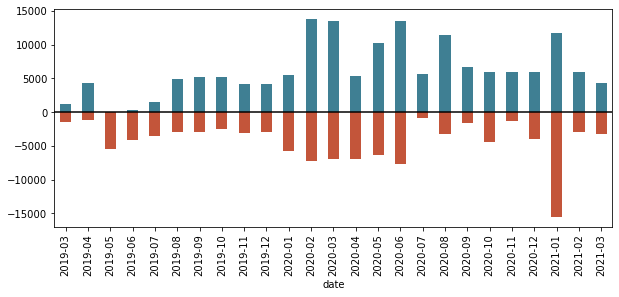

In [65]:
fig, ax = plt.subplots(figsize=(10, 4))

blue = sns.diverging_palette(220, 20)[0]
red = sns.diverging_palette(220, 20)[-1]

# Plot deposits positive
ax = monthly['deposit'].plot(kind='bar', ax=ax, color=blue)

# Plot withdrawals negative
ax = (-1*monthly['withdrawal']).plot(kind='bar', ax=ax, color=red)

# Add horizontal line
ax.axhline(0, c='k')

# 
_ = ax.set_xticklabels(monthly.index.strftime('%Y-%m'))

Ok looking at the revenue first:
- No revenue in May and June 2019. That makes sense, I was on my road trip then. 
- Slight revenue July 2019 -- again, makes sense. I started at Biobot late July.
- Then pretty stable revenue through the end of 2019, around roughly $5000. That was my original Biobot salary.

Let's see what happened in February, March, May, and June of 2020...

In [71]:
# Feb
df.query('date >= "2020-02-01"').query('date < "2020-03-01"')

,date,type,check_num,description,withdrawal,deposit,runningbalance,month,year
152,2020-02-28,INTADJUST,NaN,Interest Paid,NaN,3.21,30423.68,2,2020
153,2020-02-28,ACH,NaN,GUSTO PAY 364988 200228,NaN,2103.98,30420.47,2,2020
154,2020-02-25,ACH,NaN,CARDMEMBER SERV WEB PYMT 200223,15.00,NaN,28316.49,2,2020
155,2020-02-24,ACH,NaN,VENMO PAYMENT,40.00,NaN,28331.49,2,2020
156,2020-02-19,ACH,NaN,Boston Property RESIDENT,5250.00,NaN,28371.49,2,2020
157,2020-02-18,ACH,NaN,VENMO CASHOUT,NaN,2999.00,33621.49,2,2020
158,2020-02-18,ACH,NaN,VENMO CASHOUT,NaN,1468.00,30622.49,2,2020
159,2020-02-18,ACH,NaN,GUSTO PAY 309760 200218,NaN,2103.98,29154.49,2,2020
160,2020-02-10,ACH,NaN,CITI CARD ONLINE PAYMENT 200209,878.86,NaN,27050.51,2,2020
161,2020-02-06,ATM,NaN,7ELEVEN-FCTI 600 TECHNO CAMBRIDGE,60.00,NaN,27929.37,2,2020


Ok so two things happened in February:
- I cashed out my Venmo. I think this was when I started paying rent for the house (my roommate Andee moved out in March, and I took over from her then). Our total rent was $5250, so that means I would have gotten $4200 from my housemates. I use Venmo for other things, so 2999+1468 = 4,467. Ok so there's an extra ~$200 in there, dunno where that would come from. Probably left over from other things.
- My dad gave me part of the car money.

In [72]:
# March
df.query('date >= "2020-03-01"').query('date < "2020-04-01"')

,date,type,check_num,description,withdrawal,deposit,runningbalance,month,year
135,2020-03-31,INTADJUST,NaN,Interest Paid,NaN,2.31,36902.87,3,2020
136,2020-03-31,ATMREBATE,NaN,ATM Fee Rebate,NaN,3.25,36900.56,3,2020
137,2020-03-31,ACH,NaN,CARDMEMBER SERV WEB PYMT 200329,21.14,NaN,36897.31,3,2020
138,2020-03-31,ACH,NaN,GUSTO PAY 507925 200331,NaN,2103.98,36918.45,3,2020
139,2020-03-30,ACH,NaN,CITI CARD ONLINE PAYMENT 200329,993.08,NaN,34814.47,3,2020
140,2020-03-23,ACH,NaN,VENMO PAYMENT,15.00,NaN,35807.55,3,2020
141,2020-03-22,ATM,NaN,USAACATM19 219 CAMBRIDG ALLSTON,403.25,NaN,35822.55,3,2020
142,2020-03-19,ACH,NaN,Boston Property RESIDENT,5250.00,NaN,36225.80,3,2020
143,2020-03-19,ACH,NaN,VENMO CASHOUT,NaN,2999.00,41475.80,3,2020
144,2020-03-19,ACH,NaN,VENMO CASHOUT,NaN,1253.20,38476.80,3,2020


Same thing in March - rent and car money explain it.

What's the deal with April then? Maybe I didn't cash out my venmo till May and June...?

In [74]:
# April
df.query('date >= "2020-04-01"').query('date < "2020-05-01"')

,date,type,check_num,description,withdrawal,deposit,runningbalance,month,year
126,2020-04-30,INTADJUST,NaN,Interest Paid,NaN,0.89,35310.33,4,2020
127,2020-04-30,ACH,NaN,GUSTO PAY 617713 200430,NaN,2101.98,35309.44,4,2020
128,2020-04-28,ACH,NaN,CARDMEMBER SERV WEB PYMT 200427,15.00,NaN,33207.46,4,2020
129,2020-04-23,ACH,NaN,Boston Property RESIDENT,5250.00,NaN,33222.46,4,2020
130,2020-04-15,ACH,NaN,GUSTO PAY 570415 200415,NaN,2103.98,38472.46,4,2020
131,2020-04-15,ACH,NaN,IRS TREAS 310 TAX REF 041520~ Tran: ACH,NaN,1200.00,36368.48,4,2020
132,2020-04-07,ACH,NaN,CITI CARD ONLINE PAYMENT 200406,1523.67,NaN,35168.48,4,2020
133,2020-04-03,ACH,NaN,BK OF AMER MC ONLINE PMT 200403,110.72,NaN,36692.15,4,2020
134,2020-04-01,TRANSFER,NaN,Funds Transfer to Brokerage -0553,100.00,NaN,36802.87,4,2020


Nice. April was the first stimulus check, $1200.

In [76]:
# May
df.query('date >= "2020-05-01"').query('date < "2020-06-01"')

,date,type,check_num,description,withdrawal,deposit,runningbalance,month,year
116,2020-05-29,INTADJUST,NaN,Interest Paid,NaN,0.95,39247.08,5,2020
117,2020-05-29,ACH,NaN,GUSTO PAY 747446 200529,NaN,2366.10,39246.13,5,2020
118,2020-05-27,ACH,NaN,Boston Property RESIDENT,5250.00,NaN,36880.03,5,2020
119,2020-05-27,ACH,NaN,CARDMEMBER SERV WEB PYMT 200523,15.00,NaN,42130.03,5,2020
120,2020-05-27,ACH,NaN,CITI CARD ONLINE PAYMENT 200526,823.53,NaN,42145.03,5,2020
121,2020-05-15,ACH,NaN,GUSTO PAY 681355 200515,NaN,4866.09,42968.56,5,2020
122,2020-05-14,ACH,NaN,SKYPE COMMUNICATIONS SARL IAT PAYPAL USD,5.00,NaN,38102.47,5,2020
123,2020-05-04,ACH,NaN,VENMO CASHOUT,NaN,2982.86,38107.47,5,2020
124,2020-05-01,TRANSFER,NaN,Funds Transfer to Brokerage -0553,100.00,NaN,35124.61,5,2020
125,2020-05-01,ACH,NaN,BK OF AMER MC ONLINE PMT 200501,85.72,NaN,35224.61,5,2020


Nothing special here. Looks like I did get a slight extra income -- I don't think I'd gotten my raise by then, so maybe this was just a one-time bonus? I think we got one of those last year...

In [77]:
# June
df.query('date >= "2020-06-01"').query('date < "2020-07-01"')

,date,type,check_num,description,withdrawal,deposit,runningbalance,month,year
90,2020-06-30,INTADJUST,NaN,Interest Paid,NaN,1.08,45078.01,6,2020
91,2020-06-30,ACH,NaN,GUSTO PAY 937605 200630,NaN,2366.09,45076.93,6,2020
92,2020-06-24,ACH,NaN,Boston Property RESIDENT,5250.00,NaN,42710.84,6,2020
93,2020-06-24,ACH,NaN,VENMO CASHOUT,NaN,2999.00,47960.84,6,2020
94,2020-06-22,ACH,NaN,VENMO CASHOUT,NaN,2999.00,44961.84,6,2020
95,2020-06-22,ACH,NaN,VENMO CASHOUT,NaN,1296.00,41962.84,6,2020
96,2020-06-15,ACH,NaN,CITI CARD ONLINE PAYMENT 200614,1145.46,NaN,40666.84,6,2020
97,2020-06-15,ACH,NaN,BK OF AMER MC ONLINE PMT 200615,146.82,NaN,41812.30,6,2020
98,2020-06-15,ACH,NaN,GUSTO PAY 833163 200615,NaN,2366.08,41959.12,6,2020
99,2020-06-12,VISA,NaN,FAMILIES FOR JUSTI617-9927185 MA #00000,100.00,NaN,39593.04,6,2020


All those paypal transfers are donations to a variety of racial and social justices organizations. This was me redistributing my stimulus check in June, after the murder of George Floyd.

Ah and I see some extra venmo cashout here. So maybe this is for May and June? Let's just remove double housemate-rent from this month.

In [85]:
# July
df.query('date >= "2020-07-01"').query('date < "2020-08-01"')

,date,type,check_num,description,withdrawal,deposit,runningbalance,month,year
82,2020-07-31,INTADJUST,NaN,Interest Paid,NaN,1.17,49774.46,7,2020
83,2020-07-31,ACH,NaN,GUSTO PAY 155581 200731,NaN,3206.17,49773.29,7,2020
84,2020-07-21,ACH,NaN,CARDMEMBER SERV WEB PYMT 200719,497.31,NaN,46567.12,7,2020
85,2020-07-20,ACH,NaN,TEEMILL TECH LTD IAT PAYPAL USDUSD,33.96,NaN,47064.43,7,2020
86,2020-07-15,ACH,NaN,GUSTO PAY 041639 200715,NaN,2366.10,47098.39,7,2020
87,2020-07-06,ACH,NaN,CARDMEMBER SERV WEB PYMT 200703,160.00,NaN,44732.29,7,2020
88,2020-07-06,ACH,NaN,BK OF AMER MC ONLINE PMT 200706,85.72,NaN,44892.29,7,2020
89,2020-07-01,TRANSFER,NaN,Funds Transfer to Brokerage -0553,100.00,NaN,44978.01,7,2020


July looks normal. Though I don't see my venmo cashout... I also didn't pay rent that month. OH that's because we switched it to our housemate, probably...?

In [78]:
# August
df.query('date >= "2020-08-01"').query('date < "2020-09-01"')

,date,type,check_num,description,withdrawal,deposit,runningbalance,month,year
72,2020-08-31,INTADJUST,NaN,Interest Paid,NaN,1.37,57906.37,8,2020
73,2020-08-31,ACH,NaN,CITI AUTOPAY PAYMENT 200828,34.99,NaN,57905.00,8,2020
74,2020-08-31,ACH,NaN,GUSTO PAY 452586 200831,NaN,3206.18,57939.99,8,2020
75,2020-08-25,ACH,NaN,CARDMEMBER SERV WEB PYMT 200824,2277.79,NaN,54733.81,8,2020
76,2020-08-19,ACH,NaN,CITI CARD ONLINE PAYMENT 200818,803.98,NaN,57011.60,8,2020
77,2020-08-19,ACH,NaN,BK OF AMER MC ONLINE PMT 200819,73.96,NaN,57815.58,8,2020
78,2020-08-19,ACH,NaN,IRS TREAS 310 TAX REF 081920~ Tran: ACH,NaN,8.91,57889.54,8,2020
79,2020-08-14,ACH,NaN,ALAIN DUVALLE CK POPMONEY 200814,NaN,5000.00,57880.63,8,2020
80,2020-08-14,ACH,NaN,GUSTO PAY 362675 200814,NaN,3206.17,52880.63,8,2020
81,2020-08-03,TRANSFER,NaN,Funds Transfer to Brokerage -0553,100.00,NaN,49674.46,8,2020


Ah, got another car transfer in August.

I paid rent Feb-August 2020. But Feb rent was for the month of March, so I would have paid August rent in July. No, my housemates paid August rent in July bc we had decided to move by then. So I paid rent Feb-June.

- Feb: I paid rent (withdrawal = 5250) and deposited housemate rent (deposit = 4200)
- March: I paid rent (withdrawal = 5250) and deposited housemate rent (deposit = 4200)
- April: I paid rent, but didn't deposite housemate rent
- May: I paid rent, and deposite housemate rent (well, only $3k worth)
- June: I paid rent, and deposited housemate rent (7.3k, which is two month's worth of three housemates). I think one of my housemates paid me late...? Or maybe Ben paid me back through other means not captured on venmo? Anyway, let's just consider this month having two months' worth of house money shenanigans.
- July: I didn't pay rent and didn't deposit housemate rent. This might have been when we switched over to someone else? I think we decided to move out mid-July, but finally moved out early August.

Questions:
- can I negate the rent money I got and paid? Just remove $4,200 from deposit and withdrawal for the period I paid rent?

- let's remove money from my dad from this analysis, description includes "ALAIN DUVALLE CK POPMONEY"

In [87]:
# Recalculate monthly expenses/withdrawals after removing dad's car payments
# and my car down payment

# Remove dad's car payments
df = df.loc[~df['description'].str.contains('ALAIN DUVALLE CK POPMONEY')]

# Remove my car payment
df = df.query('withdrawal != 15000')

In [92]:
# Recalculate monthly deposit and withdrawals
monthly = df.groupby(['year', 'month']).sum()[['withdrawal', 'deposit']].reset_index()
monthly = monthly.sort_values(by=['year', 'month'], ascending=[True, True])

# Make a date column for easier plotting (fingers crossed)
monthly['date'] = pd.to_datetime(monthly['year'].astype(str) + '-' + monthly['month'].astype(str))
monthly = monthly.set_index('date')

# Remove $4200 from withdrawal and deposit for months where I paid/got rent money

# Months where I paid $5250 (but in reality only paid 1050, my part of the rent)
edit_dates_withdrawal = ['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01']
for date in edit_dates_withdrawal:
    monthly.loc[date, 'withdrawal'] = monthly.loc[date, 'withdrawal'] - 4200

# Months where I need to remove $4200's worth of deposits, bc it was rent money from housemates
# June is in here twice bc I skipped April
edit_dates_deposit = ['2020-02-01', '2020-03-01', '2020-05-01', '2020-06-01', '2020-06-01']
for date in edit_dates_deposit:
    monthly.loc[date, 'deposit'] = monthly.loc[date, 'deposit'] - 4200



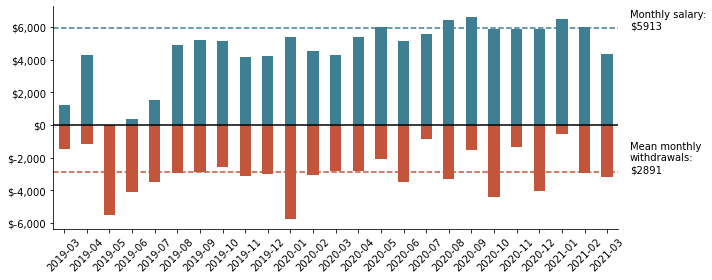

In [130]:
fig, ax = plt.subplots(figsize=(10, 4))

blue = sns.diverging_palette(220, 20)[0]
red = sns.diverging_palette(220, 20)[-1]

# Plot deposits positive
ax = monthly['deposit'].plot(kind='bar', ax=ax, color=blue)

# Plot withdrawals negative
ax = (-1*monthly['withdrawal']).plot(kind='bar', ax=ax, color=red)

# Add horizontal line at 0
ax.axhline(0, c='k')

# And for the average of my withdrawals, and my monthly salary for deposits
mean_withdrawals = monthly.mean()['withdrawal']
ax.axhline(-1*mean_withdrawals, c=red, linestyle='--')
ax.text(25, -mean_withdrawals, f'Mean monthly\nwithdrawals:\n${mean_withdrawals:.0f}')

# Salary after taxes and savings are removed
salary = 2*2956.40
ax.axhline(salary, c=blue, linestyle='--')
ax.text(25, salary, f'Monthly salary:\n${salary:.0f}')

# Format axes
_ = ax.set_xticklabels(monthly.index.strftime('%Y-%m'), rotation=45)
_ = ax.set_yticklabels(['${:,.0f}'.format(y) for y in ax.get_yticks()])
ax.set_xlabel('')

sns.despine()

fig.tight_layout()

In [107]:
ax.text?

Ok that looks a lot more reasonable now.

Interestingly, my expenses haven't really gotten much lower since moving to New Hampshire. Looks like I had an average of ~$3000-$3500 per month (except Jan 2020, which is probably bc that's from my trip to San Diego and SF with Ben and my family, so that's probably flights plus our few days in SF?).

Covid hit in March and things really closed down late March, so the lower April spending would have been reflected in my May credit card statement. You do see a slight dip in May. Then an uptick in June, when I donated a lot of money to causes. July is very low; that was a dark month with a lot of nothing. 

August spikes back up because of moving costs; we moved to NH then. Interestingly there's this two month pattern -- I think this was me and Ben auto-correcting for splitting moving expenses. For example, I bought a lot of the big stuff like our fridge and toaster oven. We spent about $6k in total for moving expenses, I think.

I also got Christmas gifts a little early, so that may be the October spike. And I bought a couch in December, so that's likely that!

Interestingly, my expenses are back up to \\$3000 the last two months. I wonder if this is because Ben has been using my credit card for all of our meal kits, and I've been paying for most of the groceries? We do pay for two meal kit subscriptions (hey, don't judge - our kitchen is tiny and miserable to cook in. This has been the most sustainable solution), but there's no way that's it?

Oh wait, duh. No it's because I bought a car so now I have an additional \\$460 monthly payment. I also got Ben an ice cream maker for his bday, which I guess would be reflected in the March expenses bc it was on my Feb credit card statement. And in Feb I also paid an extra ~$500 to register my car in New Hampshire.

I wonder if next month's expenses will go back down to "normal" NH levels? Though tbh, given that we're looking to move it doesn't seem like moving to New Hampshire saved me any money!! My average expenses are basically what they were back in Boston, just a little spikier...

